# Merfish to merfish registration with tools


In [1]:
# note for merfish to merfish she used teh same slice I aligned to visium
# and then another one (S2R2)
# S2R3 and S2

In [2]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd # for csv.
from matplotlib import cm
from matplotlib.lines import Line2D
import os
import glob
import torch

from scipy.stats import rankdata
import nrrd
import time

import tools

In [3]:
files = glob.glob('/mnt/data/merfish/OneDrive_1_8-5-2021/*metadata*.csv.gz')
files.sort()
files

['/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate1_cell_metadata_S1R1.csv.gz',
 '/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate2_cell_metadata_S1R2.csv.gz',
 '/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate3_cell_metadata_S1R3.csv.gz',
 '/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate1_cell_metadata_S2R1.csv.gz',
 '/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate2_cell_metadata_S2R2.csv.gz',
 '/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_metadata_S2R3.csv.gz',
 '/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice3_Replicate1_cell_metadata_S3R1.csv.gz',
 '/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_Brai

<IPython.core.display.Javascript object>


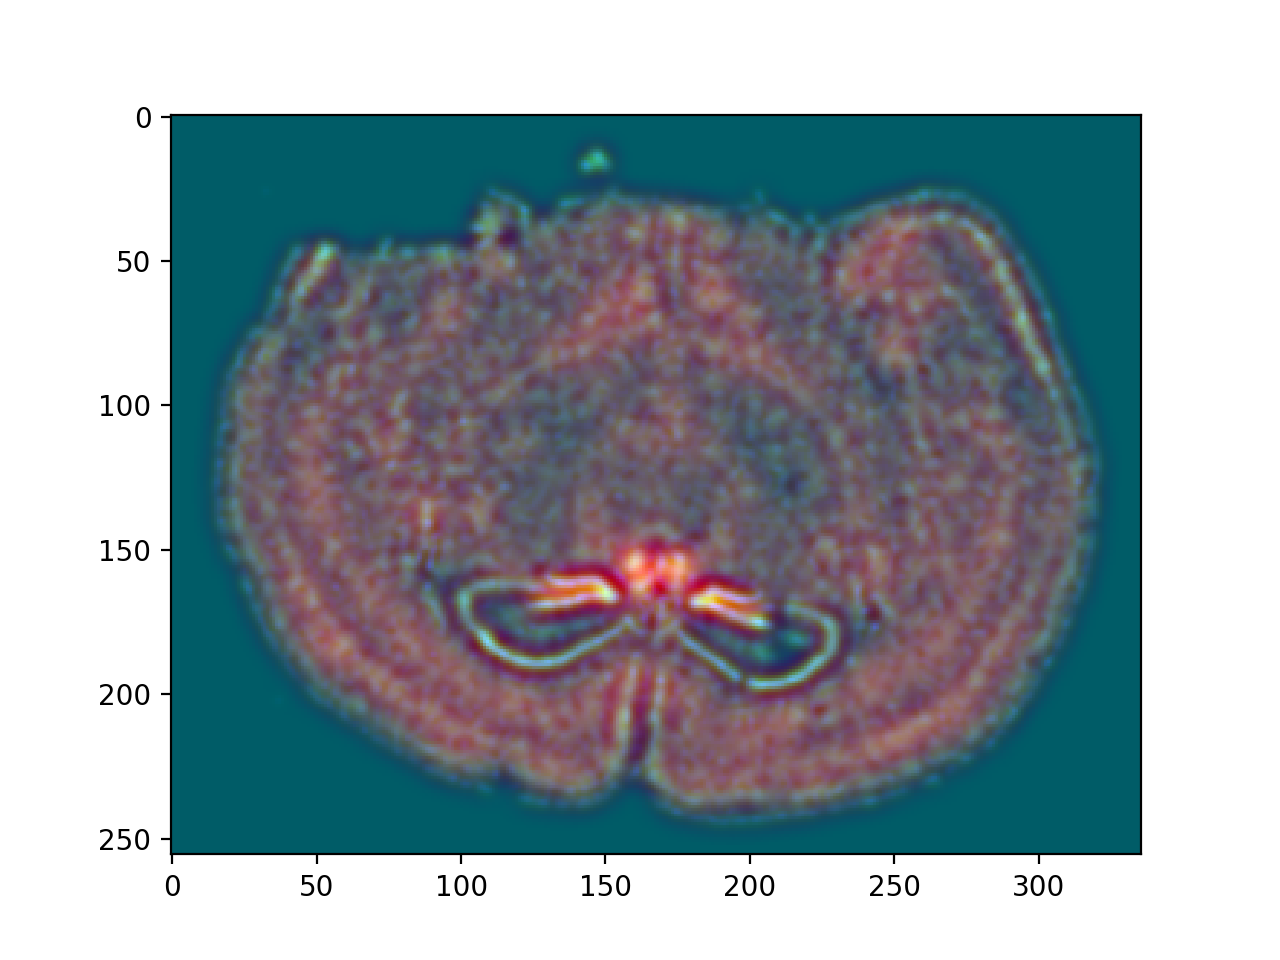

0 of 85958
10000 of 85958
20000 of 85958
30000 of 85958
40000 of 85958
50000 of 85958
60000 of 85958
70000 of 85958
80000 of 85958
85957 of 85958


In [4]:

fname = files[-4]

names = os.path.splitext(fname)
if names[1] == '.gz':
    names = os.path.splitext(names[0])
outname = names[0] + '_with_structure_id_v02.csv'


df = pd.read_csv(fname.replace('by_gene','metadata'))
xI = np.array(df['center_x'])
yI = np.array(df['center_y'])
vI = np.array(df['volume'])

import imp
imp.reload(tools)
blur = [2.0,1.0,0.5]

draw = 10000
wavelet_magnitude = True
dx = 30.0
use_windowing = True
XI,YI,I,fig = tools.rasterize(xI,yI,dx=dx,blur=blur,draw=draw, wavelet_magnitude=wavelet_magnitude, use_windowing=use_windowing)

<IPython.core.display.Javascript object>


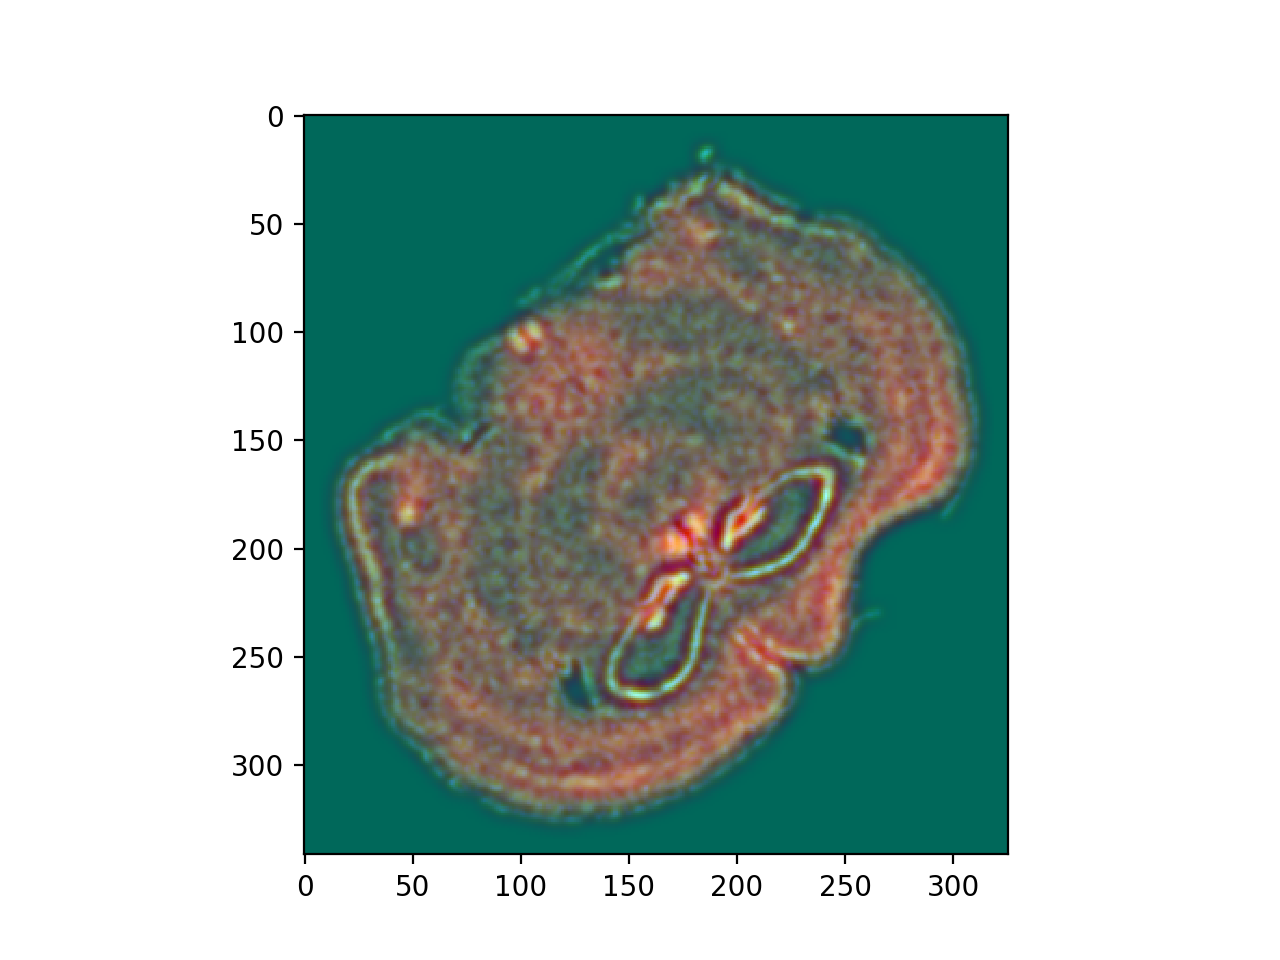

0 of 84172
10000 of 84172
20000 of 84172
30000 of 84172
40000 of 84172
50000 of 84172
60000 of 84172
70000 of 84172
80000 of 84172
84171 of 84172


In [5]:
fname = files[-5]

names = os.path.splitext(fname)
if names[1] == '.gz':
    names = os.path.splitext(names[0])
outname = names[0] + '_with_structure_id_v02.csv'


df = pd.read_csv(fname.replace('by_gene','metadata'))
xJ = np.array(df['center_x'])
yJ = np.array(df['center_y'])
vJ = np.array(df['volume'])


XJ,YJ,J,fig = tools.rasterize(xJ,yJ,dx=dx,blur=blur,draw=draw, wavelet_magnitude=wavelet_magnitude, use_windowing=use_windowing)

<IPython.core.display.Javascript object>


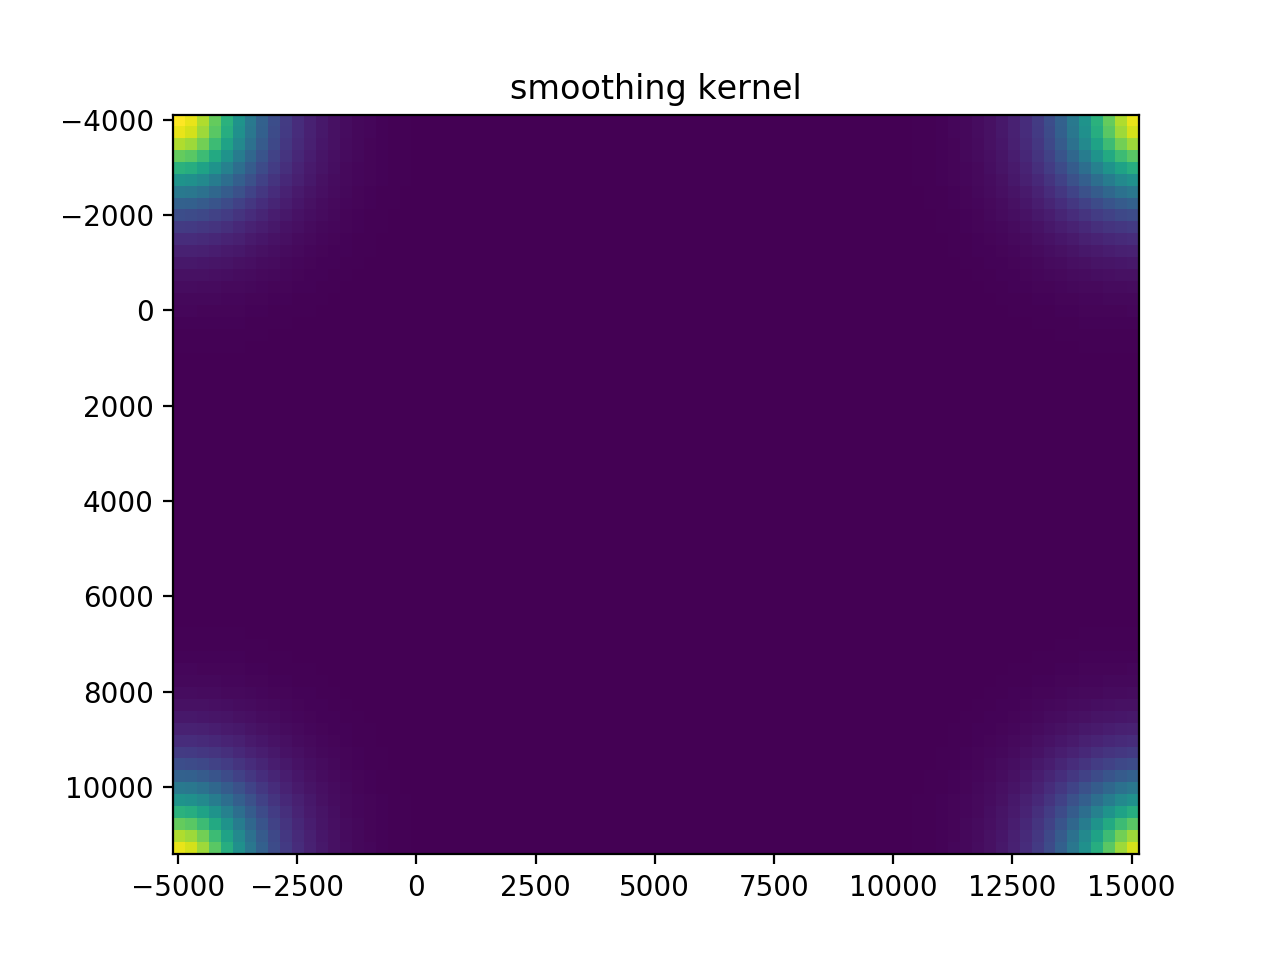

<IPython.core.display.Javascript object>


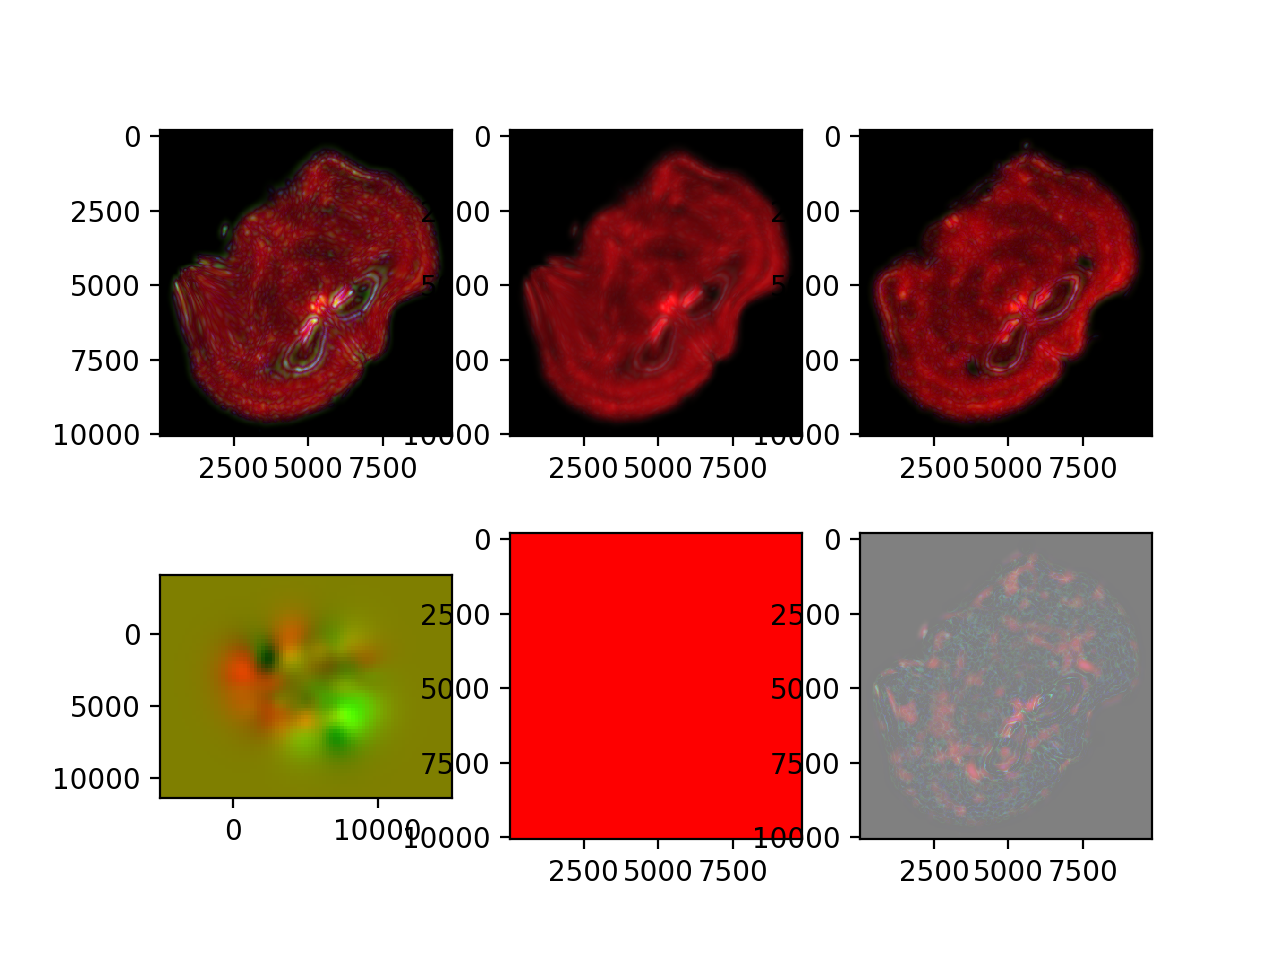

<IPython.core.display.Javascript object>


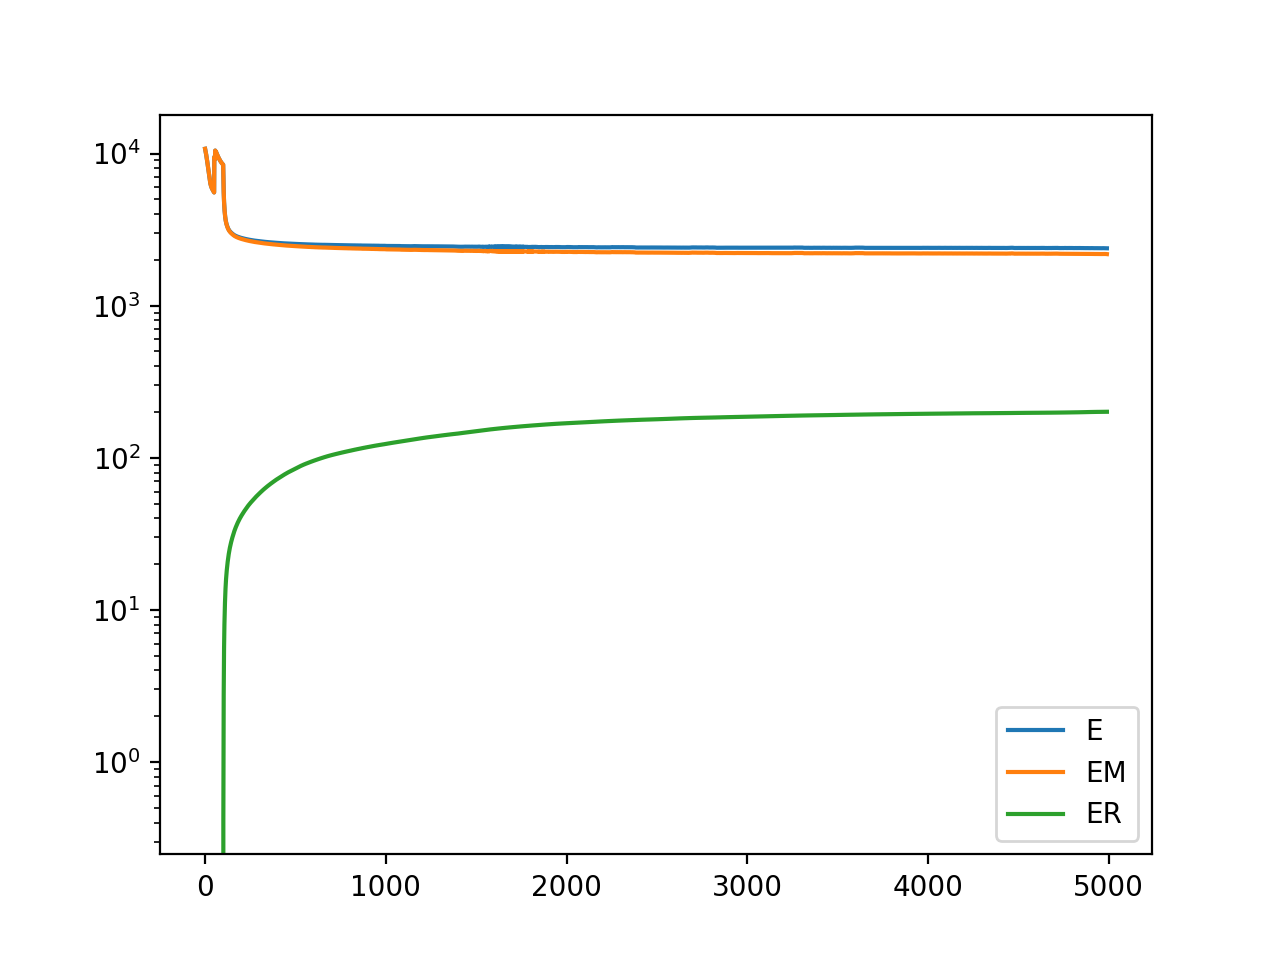

In [8]:
imp.reload(tools)
theta = 45*np.pi/180
out = tools.LDDMM([YI,XI],I,[YJ,XJ],J,
            L=np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]]),
            T=np.array([5000,-1000.0]),
             device='cuda:0')